# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

**Установим необходимые библиотеки.**

In [1]:
!pip install chart_studio -q
!pip install cufflinks -q
!pip install phik -q
!pip install -U scikit-learn -q

**Импортируем библиотеки для работы с данными, графиками и моделями.**

In [2]:
import pandas as pd
from IPython.display import display
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#import plotly
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import phik

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from scipy import stats as st

**Считаем данные из csv-файла `/datasets/geo_data_0.csv` в датафрейм, сохраним в переменную и выведем несколько первых строк. Выведем общую информацию загруженного датафрейма.**

In [3]:
pth = '/datasets/geo_data_0.csv'

if os.path.exists(pth):
    geo_data_0 = pd.read_csv(pth, sep=',')
else:
    print('Something is wrong')

display(geo_data_0)
geo_data_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Считаем данные из csv-файла `/datasets/geo_data_1.csv` в датафрейм, сохраним в переменную и выведем несколько первых строк. Выведем общую информацию загруженного датафрейма.**

In [4]:
pth = '/datasets/geo_data_1.csv'

if os.path.exists(pth):
    geo_data_1 = pd.read_csv(pth, sep=',')
else:
    print('Something is wrong')

display(geo_data_1)
geo_data_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Считаем данные из csv-файла `/datasets/geo_data_2.csv` в датафрейм, сохраним в переменную и выведем несколько первых строк. Выведем общую информацию загруженного датафрейма.**

In [5]:
pth = '/datasets/geo_data_2.csv'

if os.path.exists(pth):
    geo_data_2 = pd.read_csv(pth, sep=',')
else:
    print('Something is wrong')

display(geo_data_2)
geo_data_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Проверим данные на наличие дубликатов.**

In [6]:
print('Количество явных дублей geo0: ', geo_data_0.duplicated(subset='id').sum())
print('Количество явных дублей geo1: ', geo_data_1.duplicated(subset='id').sum())
print('Количество явных дублей geo2: ', geo_data_2.duplicated(subset='id').sum())

Количество явных дублей geo0:  10
Количество явных дублей geo1:  4
Количество явных дублей geo2:  4


In [7]:
geo_data_0.drop_duplicates(subset='id', inplace=True, ignore_index=True)
geo_data_1.drop_duplicates(subset='id', inplace=True, ignore_index=True)
geo_data_2.drop_duplicates(subset='id', inplace=True, ignore_index=True)
print('Количество явных дублей geo0: ', geo_data_0.duplicated(subset='id').sum())
print('Количество явных дублей geo1: ', geo_data_1.duplicated(subset='id').sum())
print('Количество явных дублей geo2: ', geo_data_2.duplicated(subset='id').sum())

Количество явных дублей geo0:  0
Количество явных дублей geo1:  0
Количество явных дублей geo2:  0


**Проверим данные на наличие выбросов.**

In [8]:
def show_violinplot(df):
    for column in df.select_dtypes(include='number').columns.to_list():
        fig = px.violin(df, y=column, box=True)
        fig.update_layout(title_text=f'Распределение данных в колонке {column}')
        fig.show()
        print(df[column].describe())       

show_violinplot(pd.concat([geo_data_0, geo_data_1, geo_data_2])) 

**Изучим взаимосвязь между признаками. Построим тепловые карты.**

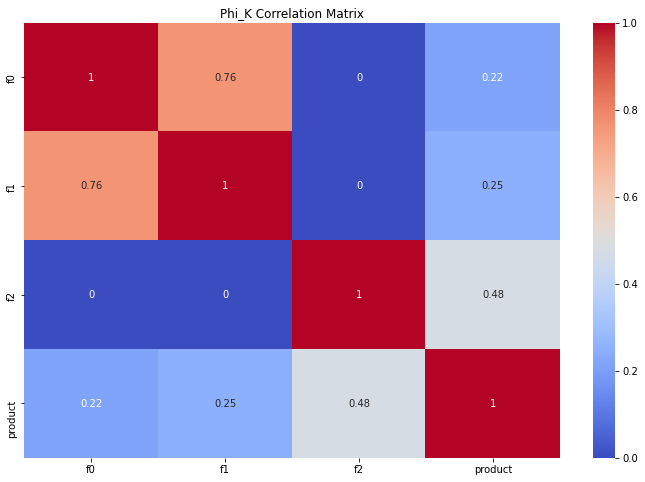

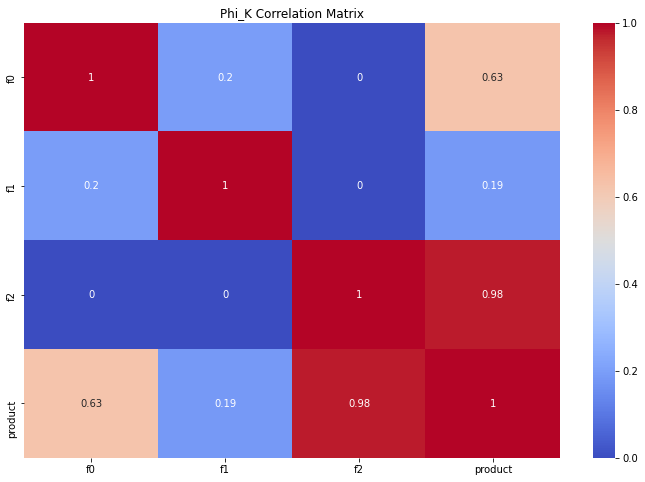

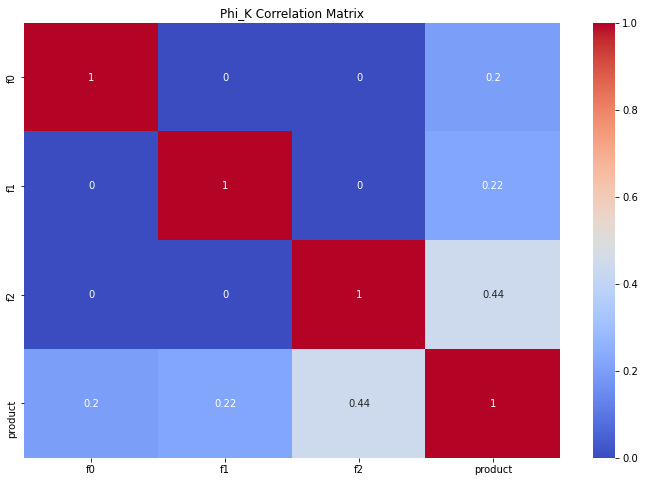

In [9]:
interval_cols = ['f0', 'f1', 'f2', 'product']

# Вычисление матрицы корреляции с использованием phik
corr_matrix = geo_data_0.drop(columns=['id']).phik_matrix(interval_cols=interval_cols)

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

corr_matrix = geo_data_1.drop(columns=['id']).phik_matrix(interval_cols=interval_cols)

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

corr_matrix = geo_data_2.drop(columns=['id']).phik_matrix(interval_cols=interval_cols)

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Выбросы и артефакты в данных отсутствуют. Так как планируется использование линейной модели, делать проверку на корреляцию признаков не будем.

У второго датасета присутствует корреляция с целевым признаком с коэффициентом 1.

Приступим к обучению моделей.

## Обучение и проверка модели

**Создадим и построим пайплайн. Разместим необходимую обработку внутри пайплайна.**

In [10]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train_g0, X_valid_g0 , y_train_g0, y_valid_g0 = train_test_split(
    geo_data_0.drop(['product', 'id'], axis=1),
    geo_data_0['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

num_columns = ['f0', 'f1', 'f2']

si_pipe = Pipeline(
    [('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='median'))]
)

data_preprocessor = ColumnTransformer(
    [    
     ('s_input', si_pipe, num_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [Ridge()],
        'models__alpha': [0, 10, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [Lasso()],
        'models__alpha': [0, 10, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

**Обучим модели. На каждый регион будет отдельная. С помощью пайплайна найдем лучшую модель. В качестве метрики используем оценку качества RMSE.**

In [11]:
scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

grid_search_geo0 = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer, 
    n_jobs=-1
)

grid_search_geo0.fit(X_train_g0, y_train_g0)

y_preds_geo0 = grid_search_geo0.predict(X_valid_g0)

print('Лучшая модель для g0 и её параметры:\n\n', grid_search_geo0.best_estimator_)
print('Метрика RMSE g0 на валидационной выборке:', mean_squared_error(y_valid_g0, y_preds_geo0, squared=False))
print('Средний запас g0 предсказанного сырья:', y_preds_geo0.mean())

X_train_g1, X_valid_g1 , y_train_g1, y_valid_g1 = train_test_split(
    geo_data_1.drop(['product', 'id'], axis=1),
    geo_data_1['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

grid_search_geo1 = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer, 
    n_jobs=-1
)

grid_search_geo1.fit(X_train_g1, y_train_g1)

y_preds_geo1 = grid_search_geo1.predict(X_valid_g1)

print('Лучшая модель для g1 и её параметры:\n\n', grid_search_geo1.best_estimator_)
print('Метрика RMSE g1 на валидационной выборке:', mean_squared_error(y_valid_g1, y_preds_geo1, squared=False))
print('Средний запас g1 предсказанного сырья:', y_preds_geo1.mean())

X_train_g2, X_valid_g2 , y_train_g2, y_valid_g2 = train_test_split(
    geo_data_2.drop(['product', 'id'], axis=1),
    geo_data_2['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

grid_search_geo2 = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer, 
    n_jobs=-1
)

grid_search_geo2.fit(X_train_g2, y_train_g2)

y_preds_geo2 = grid_search_geo2.predict(X_valid_g2)

print('Лучшая модель для g2 и её параметры:\n\n', grid_search_geo2.best_estimator_)
print('Метрика RMSE g2 на валидационной выборке:', mean_squared_error(y_valid_g2, y_preds_geo2, squared=False))
print('Средний запас g2 предсказанного сырья:', y_preds_geo2.mean())

Лучшая модель для g0 и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('s_input',
                                                  Pipeline(steps=[('simpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['f0', 'f1', 'f2']),
                                                 ('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=10))])
Метрика RMSE g0 на валидационной выборке: 37.685088864676324
Средний запас g0 предсказанного сырья: 92.6098140987406
Лучшая модель для g1 и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('s_input',
                                             

Согласно результатам, 1я и 3я геолокации имеют наибольший запас нефтепродуктов: 92.6 и 94.56 соответственно. А вот 2я скважина имеет наименьший объем - 68.61. Значит ее будем бурить в последнюю очередь.

## Подготовка к расчёту прибыли

**Сохраним данные для расчетов в отдельные переменные.**

In [12]:
# Количество скважин для бурения
n = 200
# Бюджет на разработку скважин 10 млрд. рублей
budget = 10000000000
# Доход на единицу нефтепродукта
revenue = 450000

**Расчитаем точку безубыточности.**

In [13]:
#Себестоимость бурения одной скважины
oil_borehole_cost = budget/n
#Точка безубыточности
breakeven_point = oil_borehole_cost/revenue
print('Точка безубыточности: ', breakeven_point)

Точка безубыточности:  111.11111111111111


Если каждая скважина даст не менее 111.11 тыс. баррелей нефтепродуктов, то мы достигнем точки безубыточности. Это означает, что нельзя производить бурение на указанных месторождениях выше. С первым и третьим месторождениями, у которых средний запас составляет около 92 тысяч баррелей и более, будет проще определиться, чем с вторым, где запас почти 69 тысяч баррелей.

## Расчёт прибыли и рисков 

**Учитывая, что производить бурение планируется только в одном регионе, для расчета прибыли мы просуммируем топ-200 скважин с наибольшим объемом нефтепродуктов, затем вычтем бюджет на разработку, чтобы оценить прибыльность каждого региона.**

In [14]:
def profit(probabilities, target):
    probs_sorted = probabilities.sort_values(ascending=False)
    targets = target.iloc[probs_sorted.index][:200]
    revenue_borehole = targets.sum() * revenue - budget
    return revenue_borehole

preds_g0 = pd.Series(y_preds_geo0)
preds_g1 = pd.Series(y_preds_geo1)
preds_g2 = pd.Series(y_preds_geo2)
print('Прибыль 1й геолокации составляет: ', profit(preds_g0, y_valid_g0))
print('Прибыль 2й геолокации составляет: ', profit(preds_g1, y_valid_g1))
print('Прибыль 3й геолокации составляет: ', profit(preds_g2, y_valid_g2))

Прибыль 1й геолокации составляет:  3468529787.422388
Прибыль 2й геолокации составляет:  2415086696.681511
Прибыль 3й геолокации составляет:  2396613000.939848


Выгоднее всего проводить бурение скважин на 1й геолокации: потенциальная прибыль составит 3468529787 рублей.

In [15]:
bootstrap = 1000

state = np.random.RandomState(12345)

def risk_calc(predictions, target, count):
    values = []
    for i in range(bootstrap):
        data_sample = pd.Series(predictions).sample(500, replace = True, random_state=state)
        values.append(profit(data_sample, target))
    
    values = pd.Series(values)
   
    shape_risk = (values < 0).mean()
    
    interval = st.t.interval(alpha = 0.95,
                            df = len(values) - 1,
                            loc = values.mean(),
                            scale = values.std())
        
    print(f'Данные {count} геолокации: \n')
    print('Доверительный интервал: ', interval)    
    print('Среднее значение: ', values.mean())    
    print('Риск убытков: ', shape_risk)

risk_calc(preds_g0, y_valid_g0, 'первой')
risk_calc(preds_g1, y_valid_g1, 'второй')
risk_calc(preds_g2, y_valid_g2, 'третьей')

Данные первой геолокации: 

Доверительный интервал:  (-111412389.7383998, 946225565.1552627)
Среднее значение:  417406587.7084314
Риск убытков:  0.059
Данные второй геолокации: 

Доверительный интервал:  (35075088.90902001, 835804250.0119643)
Среднее значение:  435439669.4604922
Риск убытков:  0.019
Данные третьей геолокации: 

Доверительный интервал:  (-188081848.84848356, 899831203.0877123)
Среднее значение:  355874677.11961436
Риск убытков:  0.098


Если говорить о выборе местоположения для бурения нефтяных скважин, следует учесть несколько факторов.

- Надежность: Вторая геолокация считается наиболее надежной. Это может означать, что в этой области присутствуют стабильные геологические формации или другие факторы, делающие ее менее подверженной рискам, таким как обрушения скважин или технические проблемы.
- Прибыльность: Первая геолокация является самой прибыльной. Это может указывать на наличие высокоэффективных нефтяных месторождений или более высоких уровней добычи в этой области.
- Низкая производительность: Третья геолокация имеет наименьшую производительность. Возможно, здесь наблюдаются низкие запасы нефти, проблемы с извлечением или другие факторы, снижающие коммерческую привлекательность этой области.